In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from hmpai.training import split_participants, split_participants_custom
from hmpai.pytorch.training import train_and_test
from hmpai.pytorch.utilities import set_global_seed
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from hmpai.pytorch.normalization import *
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

In [2]:
set_global_seed(42)

data_paths = [DATA_PATH / "prp/stage_data_250hz_cmb.nc"]
# 80/20 train/val (no test)
# 0.15 necessary, 15 makes 15 val samples, or 15 participants
splits = split_participants_custom(data_paths, 0.15)
labels = ["negative", "t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"]
# info_to_keep = ['event_name', 'participant', 'epochs', 'rt'] #TODO: Might not be present
info_to_keep = []
subset_cond = ('condition', 'equal', 'long')
add_negative = True
skip_samples = 0 # 62
cut_samples = 0 # 63
add_pe = True

In [3]:
norm_fn = norm_mad_zscore
train_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[0],
    normalization_fn=norm_fn,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    transform=Compose([StartJitterTransform(62, 1.0), EndJitterTransform(63, 1.0)]),
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_pe=add_pe,
)
norm_vars = get_norm_vars_from_global_statistics(train_data.statistics, norm_fn)
class_weights = train_data.statistics["class_weights"]
val_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[1],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_pe=add_pe,
)

In [7]:
data, labels = train_data.__getitem__(2)

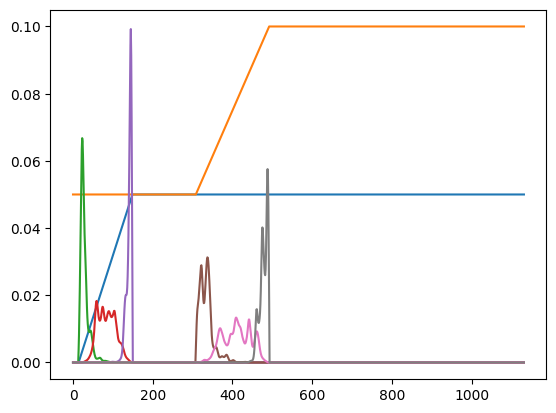

In [8]:
import matplotlib.pyplot as plt
plt.plot(data[:, -2] / 10)
plt.plot(data[:, -1] / 10)
plt.plot(labels[:, 1])
plt.plot(labels[:, 2])
plt.plot(labels[:, 3])
plt.plot(labels[:, 4])
plt.plot(labels[:, 5])
plt.plot(labels[:, 6])

In [4]:
config = {
    "n_channels": 64,
    "n_classes": len(labels),
    "n_mamba_layers": 5,
    "use_pointconv_fe": True,
    "spatial_feature_dim": 128,
    "use_conv": True,
    "conv_kernel_sizes": [3, 9],
    "conv_in_channels": [128, 128],
    "conv_out_channels": [256, 256],
    "conv_concat": True,
    "use_pos_enc": add_pe,
}
model = build_mamba(config)
train_and_test(
    model,
    train_data,
    None,
    val_data,
    logs_path=Path("../logs/"),
    workers=8,
    batch_size=32,
    lr=0.00005,
    epochs=40,
)

  0%|          | 0/275 [00:00<?, ? batch/s]

  0%|          | 0/275 [00:00<?, ? batch/s]

  0%|          | 0/275 [00:00<?, ? batch/s]

  0%|          | 0/275 [00:00<?, ? batch/s]

  0%|          | 0/275 [00:00<?, ? batch/s]

  0%|          | 0/275 [00:00<?, ? batch/s]

  0%|          | 0/275 [00:00<?, ? batch/s]

  0%|          | 0/275 [00:00<?, ? batch/s]

  0%|          | 0/275 [00:00<?, ? batch/s]

  0%|          | 0/275 [00:00<?, ? batch/s]

  0%|          | 0/275 [00:00<?, ? batch/s]

  0%|          | 0/275 [00:00<?, ? batch/s]

  0%|          | 0/275 [00:00<?, ? batch/s]

  0%|          | 0/275 [00:00<?, ? batch/s]

  0%|          | 0/275 [00:00<?, ? batch/s]

  0%|          | 0/275 [00:00<?, ? batch/s]

  0%|          | 0/275 [00:00<?, ? batch/s]